# G-Research Crypto Forecasting

Cryptocurrencies are very popular but have the disavantage to be more volatile than classical stock prices. The first cryptocurrency, Bitcoin, was created in 2008 by Satoshi Nakamoto. Bitcoin is created as a decentralized system based on the blockchain technology. However, in the next years, creation of many other cryptocurrencies has been exploded. The expansion and democratization of these methods have opened new horizons for stock market. 

In this Kaggle competition, the aim is to predict trends about cryptocurrencies by using the most well-knowledge currencies. It is important to keep in mind that forecasting stock market is a hard task and thus, forecasting trends in cryptocurrencies is more harder. 

__Datasets__

In this competition, 5 files are available : 
- A first train set,
- A supplementary train set,
- An asset set with information about cryptocurrencies,
- An example test,
- An example test submission.

__Configuration and Utils__

In [3]:
# system libraries
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.disable(logging.CRITICAL)
import gc

# data manipulation libraries
import pandas as pd
import numpy as np

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# financial analysis
from finta import TA

# modelisation libraries
from darts import TimeSeries
from functools import reduce
from datetime import datetime
import time
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.metrics import mape, mase
from darts.models import (NaiveSeasonal, NaiveDrift,
                          ExponentialSmoothing, ARIMA,
                          AutoARIMA, RegressionEnsembleModel,
                          RegressionModel, FFT)

In [4]:
def crypto_df(asset_id, data):
    # Copied from https://www.kaggle.com/odins0n/g-research-plots-eda
    df = data[data["asset_name"] == asset_id].reset_index(drop=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df


def candelstick_chart(data, title):
    # Copied from https://www.kaggle.com/odins0n/g-research-plots-eda
    candlestick = go.Figure(data=[go.Candlestick(x=data.index,
                                                 open=data[('open')],
                                                 high=data[('high')],
                                                 low=data[('low')],
                                                 close=data[('close')])])
    candlestick.update_xaxes(title_text='Time',
                             rangeslider_visible=False)

    candlestick.update_layout(
        title={
            'text': '{:} Candelstick Chart'.format(title),
            'y': 0.90,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    candlestick.update_yaxes(title_text='Price in USD', ticksuffix='$')
    return candlestick


def vol_traded(data, title, color):
    # Copied from https://www.kaggle.com/odins0n/g-research-plots-eda
    area = px.area(data_frame=data,
                   x=data.index,
                   y="volume")
    area.update_traces(line_color=color)
    area.update_xaxes(
        title_text='Time',
        rangeslider_visible=False)
    area.update_yaxes(title_text='Number of trades every minute')
    area.update_layout(showlegend=True,
                       title={
                           'text': '{:} Volume Traded'.format(title),
                           'y': 0.94,
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top'})
    return area

## 1) Preprocessing

In [5]:
df = pd.read_csv("Datasets/train.csv")
asset = pd.read_csv("Datasets/asset_details.csv")
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


Columns of the dataset :
* timestamp - A timestamp for the minute covered by the row.
* Asset_ID - An ID code for the cryptoasset.
* Count - The number of trades that took place this minute.
* Open - The USD price at the beginning of the minute.
* High - The highest USD price during the minute.
* Low - The lowest USD price during the minute.
* Close - The USD price at the end of the minute.
* Volume - The number of cryptoasset units traded during the minute.
* VWAP - The volume weighted average price for the minute.
* Target - 15 minute residualized returns.

In [6]:
# Merging dataset to obtain name of each cryptocurrency
df = pd.merge(df, asset, on="Asset_ID")
df = df[["timestamp", "Asset_Name", "Count",
         "Open", "High", "Low",
         "Close", "Volume", "VWAP",
         "Target"]]
df.columns = ["timestamp", "asset_name", "count",
              "open", "high", "low",
              "close", "volume", "vwap",
              "target"]
df.head()

,timestamp,asset_name,count,open,high,low,close,volume,vwap,target
0,1514764860,Bitcoin Cash,40.0,2376.580000,2399.5,2357.14,2374.590000,19.233005,2373.116392,-0.004218
1,1514764920,Bitcoin Cash,53.0,2374.553333,2400.9,2354.20,2372.286667,24.050259,2371.434498,-0.004079
2,1514764980,Bitcoin Cash,61.0,2371.633333,2401.9,2353.70,2372.063333,42.676438,2375.442755,-0.002892
3,1514765040,Bitcoin Cash,95.0,2376.060000,2406.4,2344.00,2370.566667,37.820918,2371.096152,-0.003718
4,1514765100,Bitcoin Cash,33.0,2372.656667,2404.6,2343.40,2370.173333,8.519679,2370.345730,-0.002171


In [7]:
df.isnull().mean() * 100

timestamp     0.000000
asset_name    0.000000
count         0.000000
open          0.000000
high          0.000000
low           0.000000
close         0.000000
volume        0.000000
vwap          0.000037
target        3.095862
dtype: float64

Only 3% of data is missing in the target column. Choice was taken to drop these data. 

In [8]:
# Deleting missing data
df.dropna(inplace=True)

## 2) Exploratory Analysis

### a) Candlestick representation

In [9]:
binance = crypto_df("Binance Coin", data=df)
btc = crypto_df("Bitcoin", data=df)
btc_cash = crypto_df("Bitcoin Cash", data=df)
cardano = crypto_df("Cardano", data=df)
dogecoin = crypto_df("Dogecoin", data=df)
eos = crypto_df("EOS.IO", data=df)
eth = crypto_df("Ethereum", data=df)
eth_classic = crypto_df("Ethereum Classic", data=df)
iota = crypto_df("IOTA", data=df)
litecoin = crypto_df("Litecoin", data=df)
maker = crypto_df("Maker", data=df)
monero = crypto_df("Monero", data=df)
stellar = crypto_df("Stellar", data=df)
tron = crypto_df("TRON", data=df)

- Binance Coin

In [10]:
binance_plot = candelstick_chart(binance[-100:], title="Binance Coin")
binance_plot.show()

- Bitcoin

In [11]:
btc_plot = candelstick_chart(btc[-100:], title="Bitcoin")
btc_plot.show()

- Bitcoin Cash

In [12]:
btc_cash_plot = candelstick_chart(btc_cash[-100:], title="Bitcoin Cash")
btc_cash_plot.show()

- Cardano

In [13]:
cardano_plot = candelstick_chart(cardano[-100:], title="Cardano")
cardano_plot.show()

- Dogecoin

In [14]:
dogecoin_plot = candelstick_chart(dogecoin[-100:], title="Dogecoin")
dogecoin_plot.show()

- EOS.IO

In [15]:
eos_plot = candelstick_chart(eos[-100:], title="EOS.IO")
eos_plot.show()

- Ethereum

In [16]:
eth_plot = candelstick_chart(eth[-100:], title="Ethereum")
eth_plot.show()

- Ethereum Classic

In [17]:
eth_classic_plot = candelstick_chart(
    eth_classic[-100:], title="Ethereum Classic")
eth_classic_plot.show()

- IOTA

In [18]:
iota_plot = candelstick_chart(iota[-100:], title="IOTA")
iota_plot.show()

- Litecoin

In [19]:
litecoin_plot = candelstick_chart(litecoin[-100:], title="Litecoin")
litecoin_plot.show()

- Maker

In [20]:
maker_plot = candelstick_chart(maker[-100:], title="Maker")
maker_plot.show()

- Monero

In [21]:
monero_plot = candelstick_chart(monero[-100:], title="Monero")
monero_plot.show()

- Stellar

In [22]:
stellar_plot = candelstick_chart(stellar[-100:], title="Stellar")
stellar_plot.show()

- TRON

In [23]:
tron_plot = candelstick_chart(tron[-100:], title="TRON")
tron_plot.show()

### b) Volume exchange

In [24]:
vol_traded(binance[-50:], "Binance Coin", color="Red")

In [25]:
vol_traded(btc[-50:], "Bitcoin", color="Red")

In [26]:
vol_traded(btc_cash[-50:], "Bitcoin Cash", color="Red")

In [27]:
vol_traded(cardano[-50:], "Cardano", color="Red")

In [28]:
vol_traded(dogecoin[-50:], "Dogecoin", color="Red")

In [29]:
vol_traded(eos[-50:], "EOS.IO", color="Red")

In [30]:
vol_traded(eth[-50:], "Ethereum", color="Red")

In [31]:
vol_traded(eth_classic[-50:], "Ethereum Classic", color="Red")

In [32]:
vol_traded(iota[-50:], "IOTA", color="Red")

In [33]:
vol_traded(litecoin[-50:], "Litecoin", color="Red")

In [34]:
vol_traded(maker[-50:], "Maker", color="Red")

In [35]:
vol_traded(monero[-50:], "Monero", color="Red")

In [36]:
vol_traded(stellar[-50:], "Stellar", color="Red")

In [37]:
vol_traded(tron[-50:], "TRON", color="Red")

In [38]:
del binance, btc, btc_cash,\
    cardano, dogecoin, eos,\
    eth, eth_classic, iota,\
    litecoin, maker, monero,\
    stellar, tron
gc.collect()

73906

### c) Central tendency analysis

In [39]:
df.groupby("asset_name").mean()

,timestamp,count,open,high,low,close,volume,vwap,target
asset_name,,,,,,,,,
Binance Coin,1.573872e+09,187.618273,77.373193,77.472444,77.269072,77.373072,1.870322e+03,77.371074,0.000032
Bitcoin,1.573474e+09,1082.519805,15611.972286,15652.668498,15578.890342,15611.972500,9.286177e+01,15611.851834,-0.000002
Bitcoin Cash,1.573564e+09,153.906626,495.694666,497.190686,494.182455,495.690656,2.267436e+02,495.686611,-0.000005
Cardano,1.578207e+09,241.706651,0.359859,0.360598,0.359182,0.359860,3.336621e+05,0.359851,0.000002
Dogecoin,1.597307e+09,542.125557,0.075664,0.075846,0.075495,0.075664,2.760949e+06,0.075664,0.000042
EOS.IO,1.573556e+09,245.836163,4.892420,4.908410,4.879162,4.892409,2.758561e+04,4.892364,-0.000001
Ethereum,1.573473e+09,689.178027,706.102473,707.939808,704.416285,706.103484,1.136452e+03,706.096307,-0.000002
Ethereum Classic,1.573602e+09,130.125125,15.396916,15.500340,15.328908,15.396951,3.395385e+03,15.396846,0.000037
IOTA,1.578410e+09,37.375503,0.642305,0.648145,0.636517,0.642304,1.516205e+04,0.642286,0.000016


In [40]:
df.groupby("asset_name").median()

,timestamp,count,open,high,low,close,volume,vwap,target
asset_name,,,,,,,,,
Binance Coin,1574143110,46.0,18.209850,18.222100,18.197000,18.209600,1028.000000,18.208485,-0.000019
Bitcoin,1573497510,563.0,9206.418401,9222.810000,9191.630000,9206.437857,52.810735,9206.370125,-0.000019
Bitcoin Cash,1573708530,72.0,350.420000,351.590000,349.435000,350.404500,88.211946,350.411627,-0.000085
Cardano,1578906990,49.0,0.087456,0.087620,0.087306,0.087457,143089.046964,0.087454,-0.000062
Dogecoin,1601564550,16.0,0.003230,0.003233,0.003228,0.003231,438452.625000,0.003230,-0.000012
EOS.IO,1573591590,109.0,3.901571,3.914000,3.894800,3.901563,11968.725150,3.901549,-0.000071
Ethereum,1573500210,287.0,284.175000,284.780000,283.660000,284.172857,575.735563,284.169360,-0.000028
Ethereum Classic,1573601460,40.0,7.414060,7.465000,7.355800,7.413967,1174.306079,7.413717,-0.000062
IOTA,1578131520,13.0,0.397900,0.398700,0.397200,0.397900,5233.025000,0.397878,0.000000


In [41]:
df.groupby("asset_name").std()

,timestamp,count,open,high,low,close,volume,vwap,target
asset_name,,,,,,,,,
Binance Coin,3.388556e+07,437.947111,140.936000,141.125560,140.737355,140.935002,2.906103e+03,140.933009,0.005452
Bitcoin,3.390305e+07,1601.885017,15122.086345,15132.708981,15106.943722,15122.113935,1.554136e+02,15121.966590,0.002014
Bitcoin Cash,3.392896e+07,311.421864,396.667801,398.581937,394.641134,396.666218,4.707146e+02,396.659695,0.006478
Cardano,3.147126e+07,707.117414,0.605023,0.606310,0.603862,0.605026,6.191937e+05,0.605009,0.004510
Dogecoin,2.304441e+07,2111.115496,0.130014,0.130361,0.129686,0.130013,1.059822e+07,0.130013,0.008122
EOS.IO,3.386274e+07,612.985661,2.947017,2.957033,2.936826,2.947005,6.212702e+04,2.946933,0.004827
Ethereum,3.390392e+07,1218.514190,875.611768,876.834041,874.286987,875.612630,2.055417e+03,875.608196,0.002496
Ethereum Classic,3.389779e+07,532.685713,18.234101,18.381957,18.160997,18.234146,5.675453e+04,18.234102,0.008973
IOTA,3.347203e+07,133.636682,0.521355,0.529776,0.513197,0.521355,3.822690e+04,0.521332,0.008020


### d) Correlation between cryptocurrencies

In [42]:
df_close = df.copy()
df_close = df_close[["timestamp", "asset_name", "close"]]
df_close["timestamp"] = df_close["timestamp"].apply(
    lambda x: datetime.fromtimestamp(x))
df_close["date"] = df_close["timestamp"].astype('datetime64[s]')
df_close.set_index("date", inplace=True)
df_close.drop("timestamp", axis=1, inplace=True)
df_close = df_close[["asset_name", "close"]]
df_close["close"] = df_close["close"].apply(lambda x: np.log(x))

In [43]:
df_close_2021 = df_close.loc['01/01/2021':'01/06/2021']
df_close_2021.reset_index(inplace=True)
df_close_2021 = pd.pivot_table(
    df_close_2021, values="close", columns="asset_name", index="date")

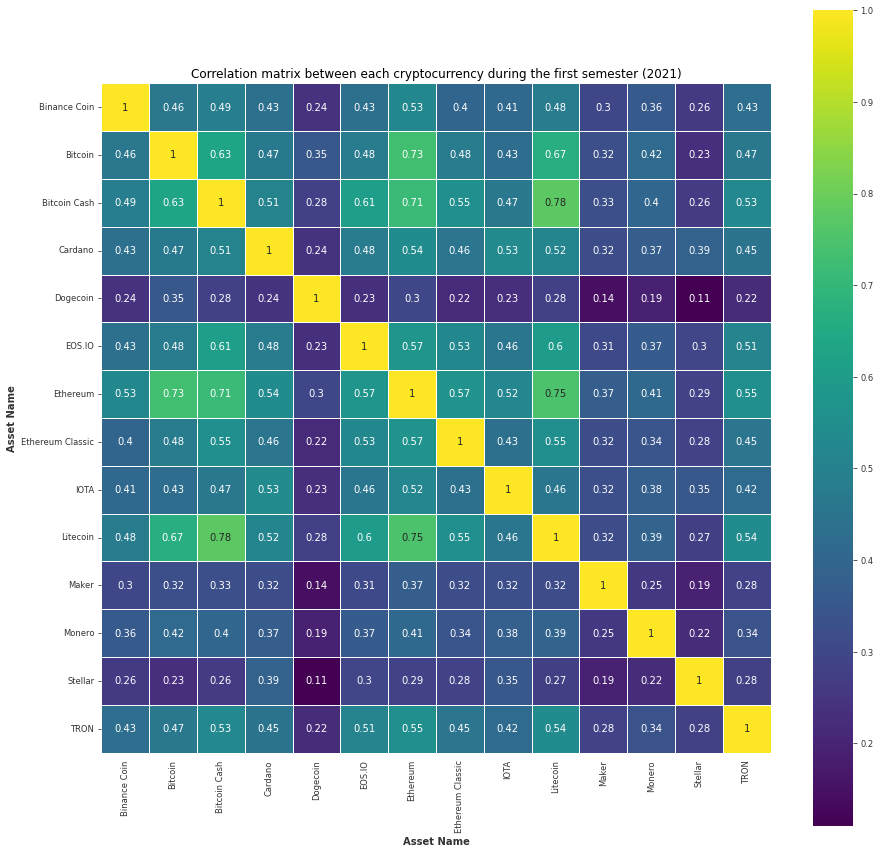

In [44]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_close_2021.diff().corr(),
            linewidths=.5,
            annot=True,
            square=True,
            cmap="viridis")
plt.xlabel("Asset Name")
plt.ylabel("Asset Name")
plt.title("Correlation matrix between each cryptocurrency during the first semester (2021)")
plt.show()

In [45]:
del df_close
del df_close_2021
gc.collect()

18327

## 3) Features Engineering

In [46]:
data = df.copy()
data = data[["timestamp", "asset_name", "open", "close", "high", "low", "volume"]]

data["timestamp"] = data["timestamp"].apply(
    lambda x: datetime.fromtimestamp(x))
data["date"] = data["timestamp"].astype('datetime64[s]')
data.set_index("date", inplace=True)
data.drop("timestamp", axis=1, inplace=True)

In [47]:
cols = ['open', 'close', "high", "low"]

for i in cols:
    data["log_"+i] = data[i].apply(lambda x: np.log(x))

### a) Creating new variables

- Variables from *Vijha et al. 2020*

1. Stock High minus Low price (H-L)
2. Stock Close minus Open price (O-C)
3. Stock price’s seven days’ moving average (7 DAYS MA)
4. Stock price’s fourteen days’ moving average (14 DAYS MA)
5. Stock price’s twenty one days’ moving average (21 DAYS MA)
6. Stock price’s standard deviation for the past seven days (7 DAYS STD DEV)

In [48]:
data["H-L"] = data["log_high"] - data["log_low"]
data["O-C"] = data["log_open"] - data["log_close"]
data["MA_7d"] = data["log_close"].rolling(10080).mean()
data["MA_14d"] = data["log_close"].rolling(20160).mean()
data["MA_21d"] = data["log_close"].rolling(30240).mean()
data["STD_7d"] = data["log_close"].rolling(10080).std()

In [49]:
data.tail()

,asset_name,open,close,high,low,volume,log_open,log_close,log_high,log_low,H-L,O-C,MA_7d,MA_14d,MA_21d,STD_7d
date,,,,,,,,,,,,,,,,
2021-09-20 23:40:00,Dogecoin,0.206413,0.206668,0.206800,0.206189,1.138012e+06,-1.577877,-1.576641,-1.576003,-1.578962,0.002959,-0.001237,-1.437337,-1.410174,-1.347084,0.042616
2021-09-20 23:41:00,Dogecoin,0.206678,0.207477,0.207600,0.206600,9.265400e+05,-1.576591,-1.572734,-1.572142,-1.576971,0.004829,-0.003857,-1.437350,-1.410194,-1.347093,0.042637
2021-09-20 23:42:00,Dogecoin,0.207441,0.207581,0.207800,0.207150,1.257670e+06,-1.572907,-1.572235,-1.571179,-1.574312,0.003133,-0.000672,-1.437362,-1.410213,-1.347102,0.042658
2021-09-20 23:43:00,Dogecoin,0.207630,0.207149,0.207806,0.207069,7.936826e+05,-1.571999,-1.574318,-1.571150,-1.574703,0.003553,0.002319,-1.437375,-1.410233,-1.347111,0.042680
2021-09-20 23:44:00,Dogecoin,0.207128,0.206629,0.207400,0.206544,8.567997e+05,-1.574420,-1.576831,-1.573106,-1.577242,0.004136,0.002411,-1.437388,-1.410253,-1.347120,0.042703


- Variable from exponential moving averages

In [50]:
data["EMA"] = data["log_close"].ewm(com=0.4).mean()

In [51]:
data.tail()

,asset_name,open,close,high,low,volume,log_open,log_close,log_high,log_low,H-L,O-C,MA_7d,MA_14d,MA_21d,STD_7d,EMA
date,,,,,,,,,,,,,,,,,
2021-09-20 23:40:00,Dogecoin,0.206413,0.206668,0.206800,0.206189,1.138012e+06,-1.577877,-1.576641,-1.576003,-1.578962,0.002959,-0.001237,-1.437337,-1.410174,-1.347084,0.042616,-1.576730
2021-09-20 23:41:00,Dogecoin,0.206678,0.207477,0.207600,0.206600,9.265400e+05,-1.576591,-1.572734,-1.572142,-1.576971,0.004829,-0.003857,-1.437350,-1.410194,-1.347093,0.042637,-1.573875
2021-09-20 23:42:00,Dogecoin,0.207441,0.207581,0.207800,0.207150,1.257670e+06,-1.572907,-1.572235,-1.571179,-1.574312,0.003133,-0.000672,-1.437362,-1.410213,-1.347102,0.042658,-1.572704
2021-09-20 23:43:00,Dogecoin,0.207630,0.207149,0.207806,0.207069,7.936826e+05,-1.571999,-1.574318,-1.571150,-1.574703,0.003553,0.002319,-1.437375,-1.410233,-1.347111,0.042680,-1.573857
2021-09-20 23:44:00,Dogecoin,0.207128,0.206629,0.207400,0.206544,8.567997e+05,-1.574420,-1.576831,-1.573106,-1.577242,0.004136,0.002411,-1.437388,-1.410253,-1.347120,0.042703,-1.575981


- Fractal Adaptive Moving Average (FRAMA)

In [52]:
data["FRAMA"] = TA.FRAMA(data)
data.head()

,asset_name,open,close,high,low,volume,log_open,log_close,log_high,log_low,H-L,O-C,MA_7d,MA_14d,MA_21d,STD_7d,EMA,FRAMA
date,,,,,,,,,,,,,,,,,,
2018-01-01 00:01:00,Bitcoin Cash,2376.580000,2374.590000,2399.5,2357.14,19.233005,7.773418,7.772580,7.783016,7.765204,0.017811,0.000838,NaN,NaN,NaN,NaN,7.772580,2374.590000
2018-01-01 00:02:00,Bitcoin Cash,2374.553333,2372.286667,2400.9,2354.20,24.050259,7.772565,7.771610,7.783599,7.763956,0.019643,0.000955,NaN,NaN,NaN,NaN,7.771825,2372.286667
2018-01-01 00:03:00,Bitcoin Cash,2371.633333,2372.063333,2401.9,2353.70,42.676438,7.771334,7.771515,7.784015,7.763744,0.020272,-0.000181,NaN,NaN,NaN,NaN,7.771599,2372.063333
2018-01-01 00:04:00,Bitcoin Cash,2376.060000,2370.566667,2406.4,2344.00,37.820918,7.773199,7.770884,7.785887,7.759614,0.026273,0.002315,NaN,NaN,NaN,NaN,7.771085,2370.566667
2018-01-01 00:05:00,Bitcoin Cash,2372.656667,2370.173333,2404.6,2343.40,8.519679,7.771766,7.770718,7.785139,7.759358,0.025781,0.001047,NaN,NaN,NaN,NaN,7.770823,2370.173333


- Relevant Strength Index (RSI)

In [53]:
data["RSI"] = TA.RSI(data)
data.tail()

,asset_name,open,close,high,low,volume,log_open,log_close,log_high,log_low,H-L,O-C,MA_7d,MA_14d,MA_21d,STD_7d,EMA,FRAMA,RSI
date,,,,,,,,,,,,,,,,,,,
2021-09-20 23:40:00,Dogecoin,0.206413,0.206668,0.206800,0.206189,1.138012e+06,-1.577877,-1.576641,-1.576003,-1.578962,0.002959,-0.001237,-1.437337,-1.410174,-1.347084,0.042616,-1.576730,NaN,44.405044
2021-09-20 23:41:00,Dogecoin,0.206678,0.207477,0.207600,0.206600,9.265400e+05,-1.576591,-1.572734,-1.572142,-1.576971,0.004829,-0.003857,-1.437350,-1.410194,-1.347093,0.042637,-1.573875,NaN,53.118524
2021-09-20 23:42:00,Dogecoin,0.207441,0.207581,0.207800,0.207150,1.257670e+06,-1.572907,-1.572235,-1.571179,-1.574312,0.003133,-0.000672,-1.437362,-1.410213,-1.347102,0.042658,-1.572704,NaN,54.109423
2021-09-20 23:43:00,Dogecoin,0.207630,0.207149,0.207806,0.207069,7.936826e+05,-1.571999,-1.574318,-1.571150,-1.574703,0.003553,0.002319,-1.437375,-1.410233,-1.347111,0.042680,-1.573857,NaN,49.414676
2021-09-20 23:44:00,Dogecoin,0.207128,0.206629,0.207400,0.206544,8.567997e+05,-1.574420,-1.576831,-1.573106,-1.577242,0.004136,0.002411,-1.437388,-1.410253,-1.347120,0.042703,-1.575981,NaN,44.419245


In [54]:
data.to_csv('Datasets/dataset_crypto.csv', index=False)

__Ressources:__
- Vijha, M., Chandolab, D., Tikkiwalb V. A., Kumar, A. (2020). Stock Closing Price Prediction using Machine Learning Techniques, *Procedia Computer Science*, 167, 599-606
- Pironi, D. (2020). The Crypto Arbitrage Opportunity. https://suiteki.medium.com/the-crypto-arbitrage-opportunity-986b78740155
- Arte. (2021). Le mystère Satoshi : Aux origines du Bitcoin. https://www.youtube.com/watch?v=0ETcLj5jBy4
- Kaabar, S. (2021). Fractal Adaptative Moving Averages. The Full Guide. https://medium.com/the-investors-handbook/fractal-adaptive-moving-average-the-full-guide-c0ae348d9497